<h1><center>Sprint 7</center></h1>
<h2><center>Tasca 1: Algoritmes d’aprenentatge supervisat: Classificació.</center></h2>

In [60]:
# Packages
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import itertools
import warnings

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, log_loss
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
from sklearn.model_selection import cross_validate

In [36]:
# file paths
data_path = 'D:/Sistema_Solar/Python/itacademy/sprint07/data/'
data_path = Path(data_path)

- Exercici 1
Crea almenys dos models de classificació diferents per intentar predir el millor les classes de l'arxiu adjunt.



- Exercici 2
Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confusió i d’altres mètriques més avançades.



- Exercici 3
Entrena’ls usant els diferents paràmetres que admeten per tal de millorar-ne la predicció.



- Exercici 4
Compara el seu rendiment fent servir l’aproximació traint/test o cross-validation.



- Exercici 5
Aplica algun procés d'enginyeria per millorar els resultats (normalització, estandardització, mostreig...)

In [37]:
# Apugem l'arxiu csv
file_name = 'wineData.txt'
file = data_path / file_name
wines = pd.read_csv(file, sep=',', header=None, encoding="ISO-8859-1")

# Afegim els noms de les columnes
colnames = ['Class', 'Alcohol', 'Malic', 'Ash', 'Alcalinity', 'Mg', 'Total phenols', 'Flavanoids', 'Nonflavanoids', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315', 'Proline']
wines.columns = colnames

In [38]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Class            178 non-null    int64  
 1   Alcohol          178 non-null    float64
 2   Malic            178 non-null    float64
 3   Ash              178 non-null    float64
 4   Alcalinity       178 non-null    float64
 5   Mg               178 non-null    int64  
 6   Total phenols    178 non-null    float64
 7   Flavanoids       178 non-null    float64
 8   Nonflavanoids    178 non-null    float64
 9   Proanthocyanins  178 non-null    float64
 10  Color intensity  178 non-null    float64
 11  Hue              178 non-null    float64
 12  OD280/OD315      178 non-null    float64
 13  Proline          178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [39]:
print(wines.describe())

            Class     Alcohol       Malic         Ash  Alcalinity          Mg  \
count  178.000000  178.000000  178.000000  178.000000  178.000000  178.000000   
mean     1.938202   13.000618    2.336348    2.366517   19.494944   99.741573   
std      0.775035    0.811827    1.117146    0.274344    3.339564   14.282484   
min      1.000000   11.030000    0.740000    1.360000   10.600000   70.000000   
25%      1.000000   12.362500    1.602500    2.210000   17.200000   88.000000   
50%      2.000000   13.050000    1.865000    2.360000   19.500000   98.000000   
75%      3.000000   13.677500    3.082500    2.557500   21.500000  107.000000   
max      3.000000   14.830000    5.800000    3.230000   30.000000  162.000000   

       Total phenols  Flavanoids  Nonflavanoids  Proanthocyanins  \
count     178.000000  178.000000     178.000000       178.000000   
mean        2.295112    2.029270       0.361854         1.590899   
std         0.625851    0.998859       0.124453         0.572359  

In [40]:
wines_matrix = wines.corr()

# Eliminarem les correlacions entre iguals per millorar la visualització posterior
for i in range(len(wines_matrix.columns)):
    for j in range(len(wines_matrix.columns)):
        if i == j:
            wines_matrix.iloc[i][j] = np.nan

<AxesSubplot:>

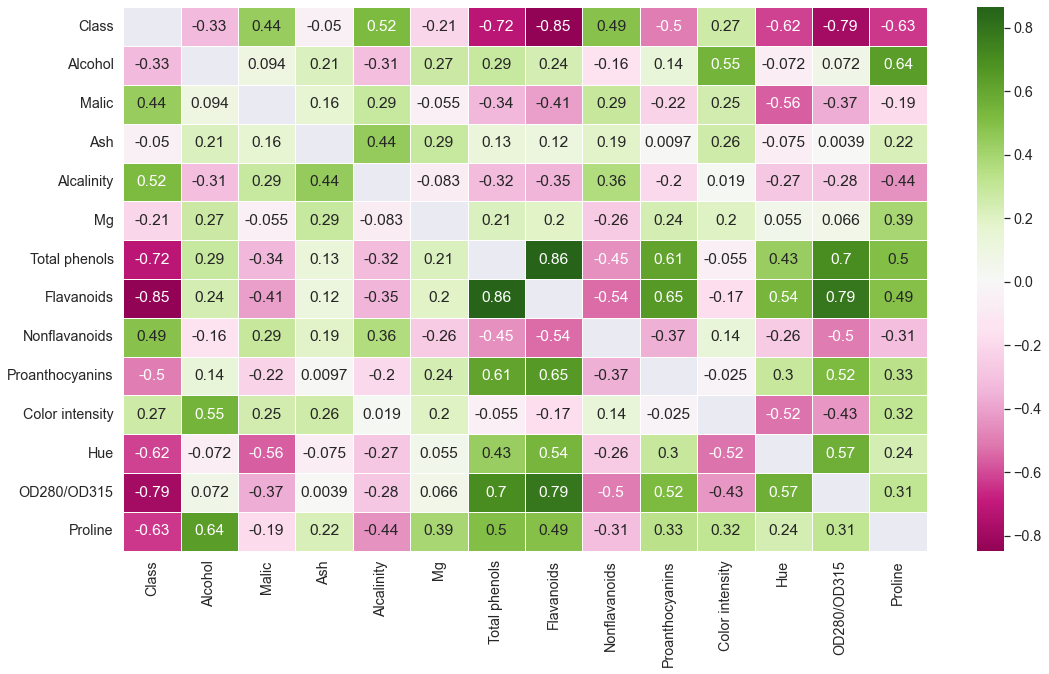

In [41]:
fig, ax = plt.subplots(figsize=(18,10))         # Sample figsize in inches
#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)

sns.heatmap(wines_matrix, annot=True, linewidth=.5, ax=ax, cmap="PiYG", center=0)

De totes les variables de ls que disposem, algunes tenen poca relació amb la classe de vins i les descartarem com són: **Ash**, **Mg** i **Color intensity**

In [42]:
wines.drop(['Ash', 'Mg', 'Color intensity'], axis=1, inplace=True)

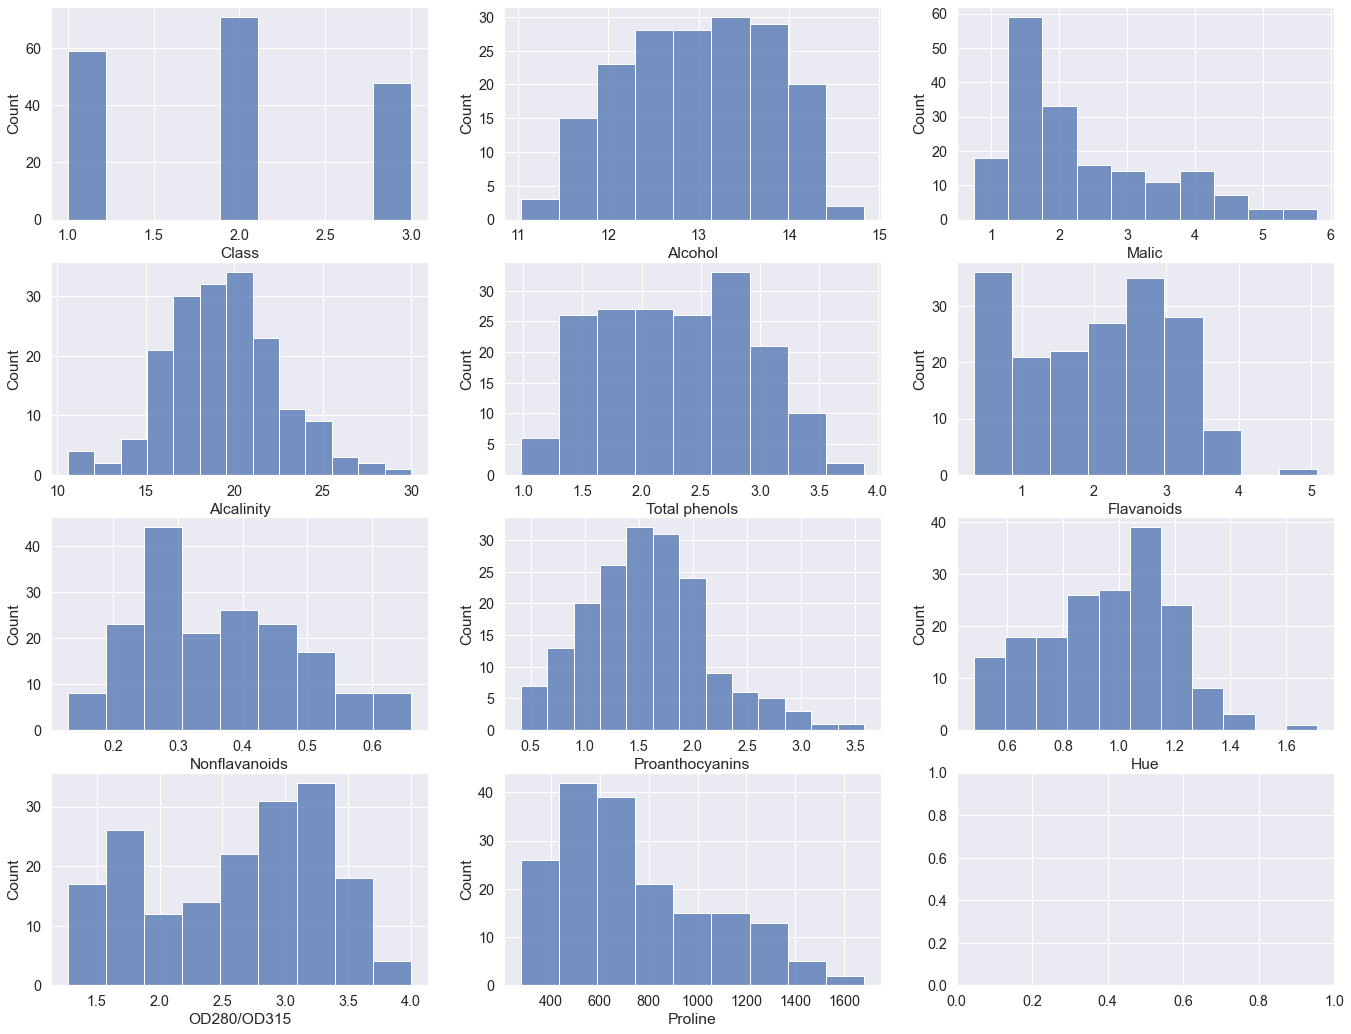

In [49]:
fig, ax = plt.subplots(4, 3, figsize=(23,18))
nrow = 0
ncol = 0

for col in wines.columns:
    sns.histplot(wines[col], ax=ax[nrow][ncol])
    ncol += 1
    if ncol == 3:
        nrow += 1
        ncol = 0

In [50]:
# Dataframe on emmagatzarem els coeficients MSE i R2 per comparar els diferents models.

coef_df = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1score'])

#### 1. Model d'arbre de decisió

In [51]:
# Separem el dataframe en un conjunt per entrenar el model i un altre per aplicar-lo.

test_size_sel = 0.3

wines_train, wines_test = train_test_split(wines, test_size=test_size_sel, random_state=42)

In [52]:
#col_sel = ['Alcohol', 'Malic', 'Alcalinity', 'Total phenols', 'Flavanoids', 'Nonflavanoids', 'Proanthocyanins', 'Hue', 'OD280/OD315', 'Proline']

x_col = wines.columns[1:]

x_train = wines_train[x_col]
y_train = wines_train['Class']

x_test = wines_test[x_col]
y_test = wines_test['Class']

Ajustem un primer model d'arbre de decisions sense definir cap paràmetre.

In [53]:
# Model d'arbre de decisió categòric

dt = DecisionTreeClassifier()

dt.fit(x_train, y_train)
dt_depth = dt.get_depth()
print(f'Decision Tree depth: {dt_depth}')
y_pred = dt.predict(x_test)
y_pred_train = dt.predict(x_train)

Decision Tree depth: 4


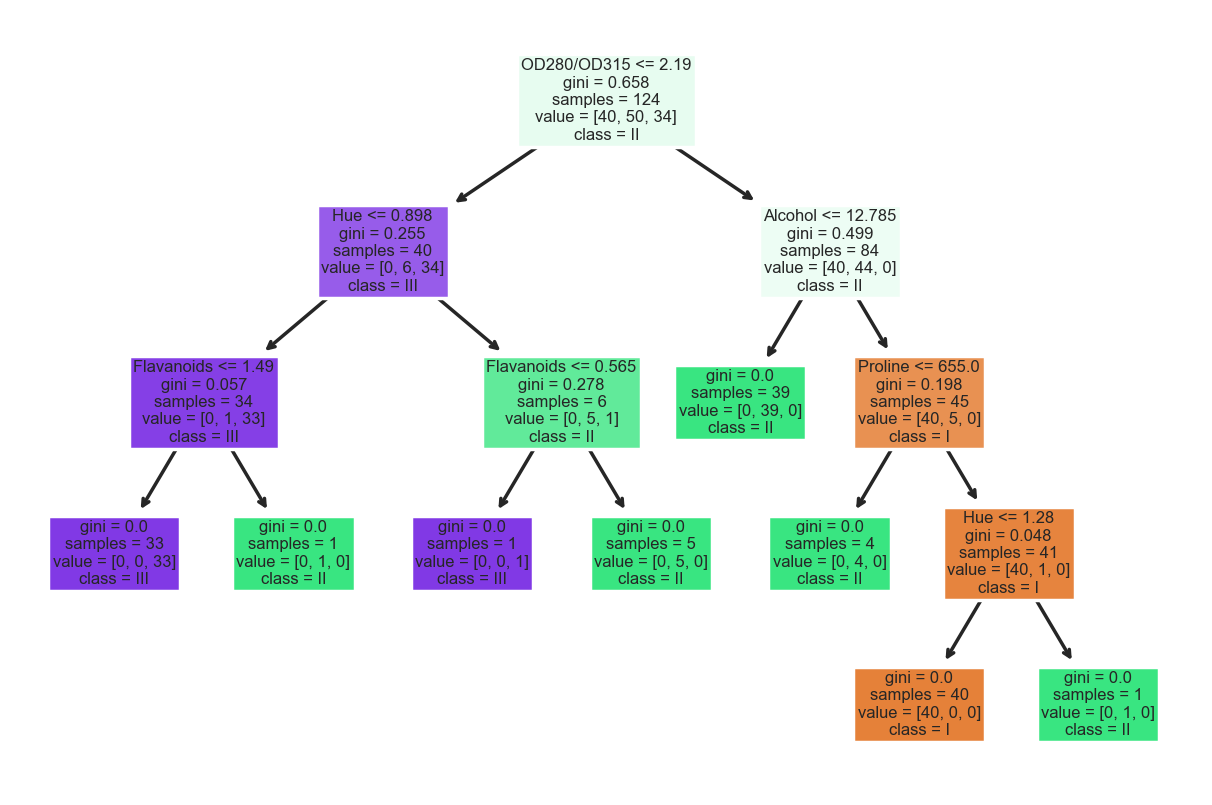

In [54]:
plt.figure(dpi=250)

cn = ['I', 'II', 'III'] 

plt.show(tree.plot_tree(dt,
               feature_names = x_col, 
               class_names=cn,
               filled = True))

El model te 4 nivells i es pot observar en el gràfic els diferents punts de bifurcació i com totes els nivells més baixes, les fulles, son totalment homogenies en relació a les clases que contenen. El model pareix que es comporta prou bé. Avaluem-lo amb diferents métodes i vegem si es pot millorar el rendiment.

In [87]:
# funció per plotejar matrius de confusió

warnings.filterwarnings( "ignore")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" 
                 if cm[i, j] > thresh 
                 else "black")

    plt.tight_layout()
    plt.ylabel('Clase vertadera')
    plt.xlabel('Clase prevista')

In [68]:
# Avaluació del model

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'model accuracy: {np.round(accuracy, 2)}')


model accuracy: 0.91


In [69]:
# matriu de confusió

confusion_train = confusion_matrix(y_train, y_pred_train, labels=[1, 2, 3])
confusion_test = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])

Confusion matrix, without normalization
[[40  0  0]
 [ 0 50  0]
 [ 0  0 34]]


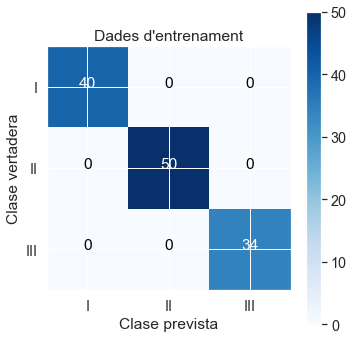

In [88]:
#fig, ax = plt.subplots(1, 2, figsize=(23,18))
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.3)
plot_confusion_matrix(confusion_train, 
                      classes=['I','II', 'III'],
                      normalize= False,  
                      title='Dades d\'entrenament')

Confusion matrix, without normalization
[[19  0  0]
 [ 0 20  1]
 [ 1  3 10]]


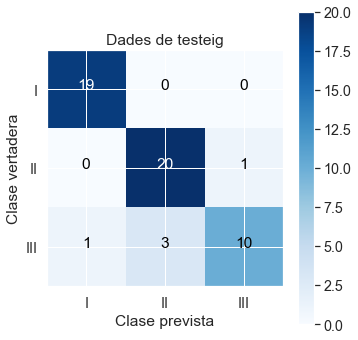

In [89]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.3)
plot_confusion_matrix(confusion_test, 
                      classes=['I','II', 'III'], ######## aqui canviar
                      normalize= False,  
                      title='Dades de testeig')

La matriu de confusió mostra com per a les dades de d'entrenament, el rendiment es perfecte, mentre que amb les dades per al testeig, 5 clases de vins no són correctament clasificades.

In [90]:
# Més coeficients d'avaluació
precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
f1score = f1_score(y_test, y_pred, average='micro')
print(f'Precision: {np.round(precision, 2)}')
print(f'Recall: {np.round(recall, 2)}')
print(f'F1 score: {np.round(f1score, 2)}')

Precision: 0.91
Recall: 0.89
F1 score: 0.91


In [91]:
coef_df['DecTree_O'] = [np.round(accuracy,2), np.round(precision, 2), np.round(recall, 2), np.round(f1score, 2)]

In [92]:
coef_df

,DecTree_O
Accuracy,0.91
Precision,0.91
Recall,0.89
F1score,0.91


El número de nivells de divisions d'aquest model era de 4, pero podem aconseguir diferents resultats si ajustem aquest paràmetre. Provarem diferents nivells màxims de 2 a 5

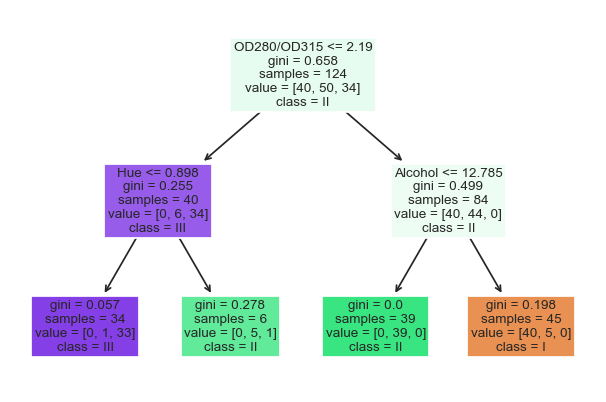

Decision Tree depth: 2
Accuracy: 0.89
Precision: 0.9
Recall: 0.88
F1 score: 0.89
dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])
[0.91919192 0.92929293 0.90909091 0.94949495 0.94      ]
[0.84       0.92       0.88       0.88       0.83333333]
----------------


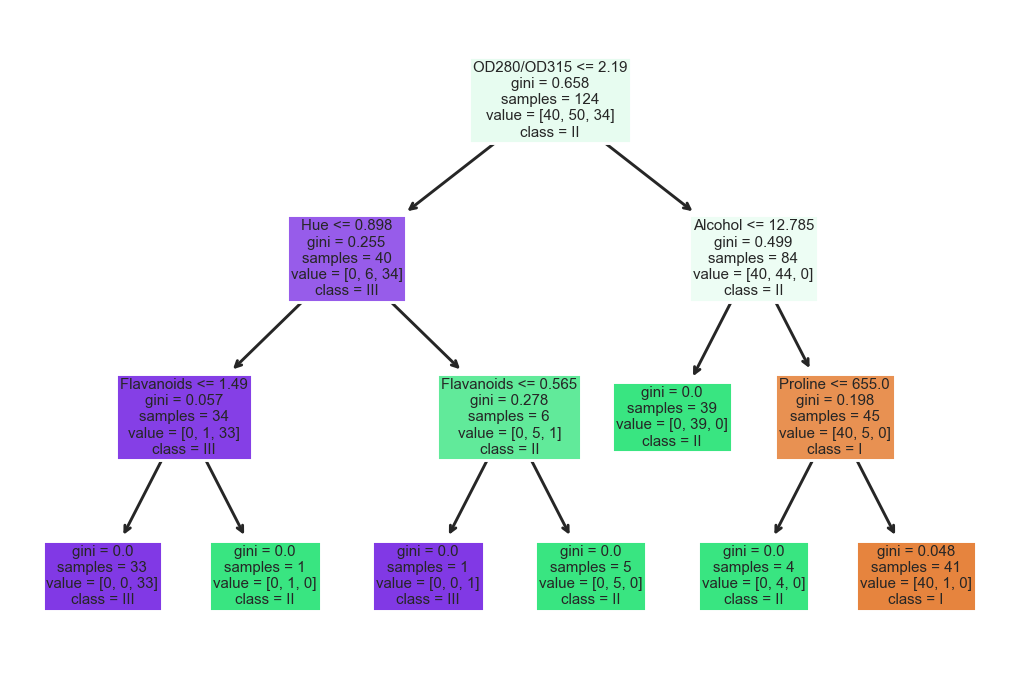

Decision Tree depth: 3
Accuracy: 0.91
Precision: 0.91
Recall: 0.89
F1 score: 0.91
dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])
[0.98989899 0.97979798 0.96969697 0.98989899 0.98      ]
[0.72       0.92       0.84       0.88       0.91666667]
----------------


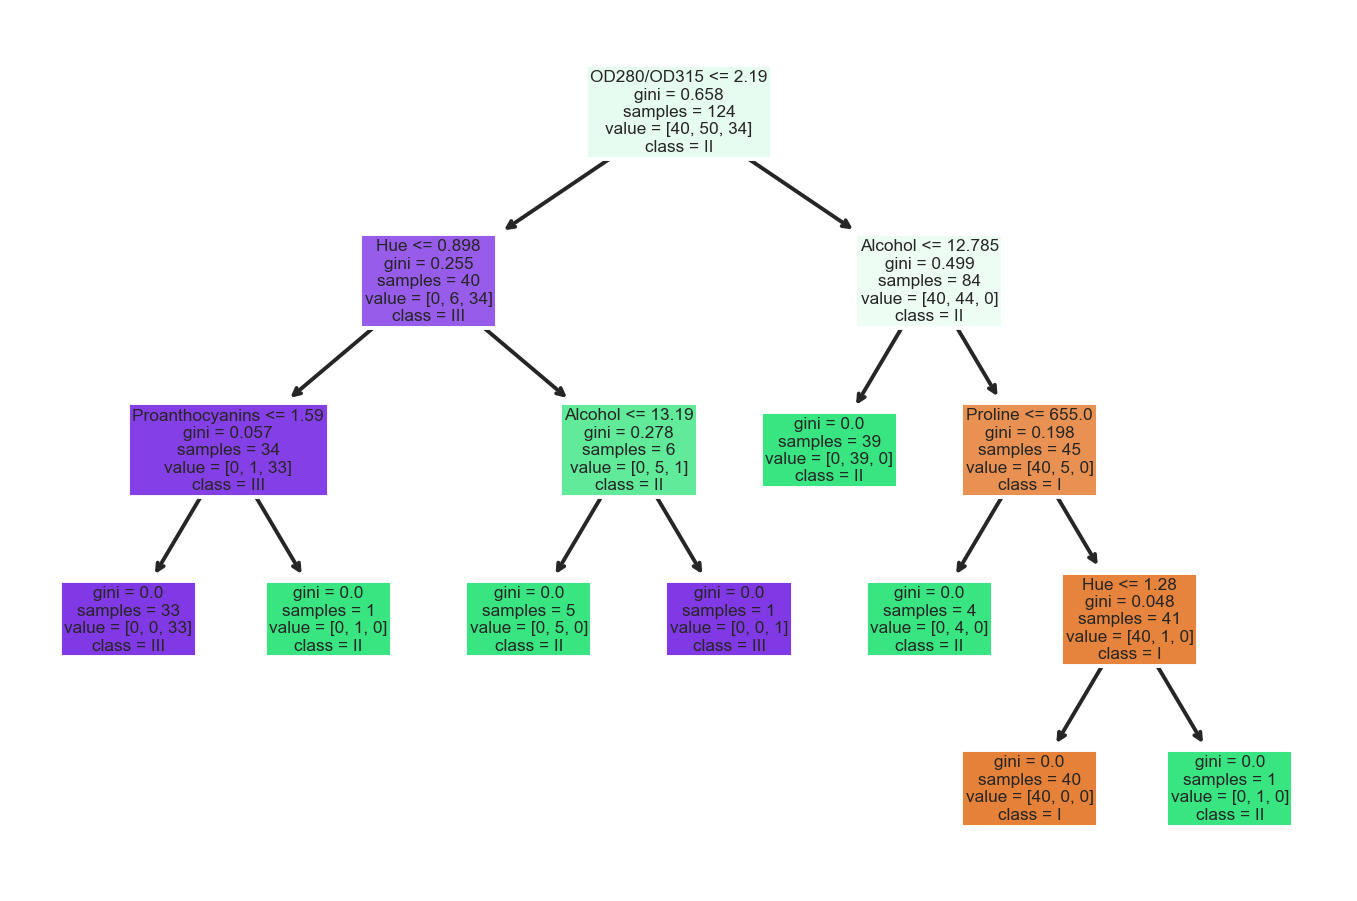

Decision Tree depth: 4
Accuracy: 0.87
Precision: 0.86
Recall: 0.85
F1 score: 0.87
dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])
[1.         0.98989899 1.         1.         0.99      ]
[0.72  1.    0.92  0.88  0.875]
----------------


In [95]:
dpi_sel = [125, 210, 280]
for depth in range(2, 5):

    dt = DecisionTreeClassifier(max_depth=depth)

    dt.fit(x_train, y_train)
    dt_depth = dt.get_depth()
    y_pred = dt.predict(x_test)
    y_pred_train = dt.predict(x_train)


    plt.figure(dpi=dpi_sel[depth-2])

    cn = ['I', 'II', 'III'] 

    plt.show(tree.plot_tree(dt,
                   feature_names = x_col, 
                   class_names=cn,
                   filled = True))
    print(f'Decision Tree depth: {dt_depth}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {np.round(accuracy, 2)}')
    
    precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
    recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
    f1score = f1_score(y_test, y_pred, average='micro')
    print(f'Precision: {np.round(precision, 2)}')
    print(f'Recall: {np.round(recall, 2)}')
    print(f'F1 score: {np.round(f1score, 2)}')
    scores = cross_validate(dt, x_train, y_train, cv=5, scoring='accuracy', return_train_score=True)
    print(scores.keys()) 
    print(scores["train_score"])
    print(scores["test_score"])
    print('----------------')

El model es comporta millor amb 3 nivells màximes. algunes de les fulles finals ja no son totalment pures però la precisió és major. Podem estudiar també, amb el métode de la validació creuada, i apreciar si hi ha o no overfitting, tal com ocorria seleccionant 4 nivells màxims.



#El model es comporta millor quan menys divisions es fan. En concret, amb dos divisons. Tot i així, veiem que el valor gni de algunes fulles finals, és superior a 0 mentre que si dividim més l'arbre la #impuressa es reduix, a banda que es precindeixen de massa variables ja que es fan poques divisions. 
#Provarem a limitar el número mínim de mostres necessàries per a crear una altra fulla amb el paràmetre min_samples_leaf

In [101]:

for depth in range(2, 5):

    dt = DecisionTreeClassifier(max_depth=depth)

    dt.fit(x_train, y_train)
    dt_depth = dt.get_depth()
    y_pred = dt.predict(x_test)
    y_pred_train = dt.predict(x_train)

    scores = cross_validate(dt, x_train, y_train, cv=5, scoring='accuracy', return_train_score=True)
    
    print(f'Decision Tree depth: {dt_depth}')
    print(f'Entrenament: {scores["train_score"]}')
    print(f'Test       : {scores["test_score"]}')
    print('----------------')

Decision Tree depth: 2
Entrenament: [0.91919192 0.92929293 0.90909091 0.94949495 0.94      ]
Test       : [0.84       0.92       0.88       0.92       0.83333333]
----------------
Decision Tree depth: 3
Entrenament: [0.98989899 0.97979798 0.96969697 0.98989899 0.98      ]
Test       : [0.76       0.92       0.92       0.88       0.91666667]
----------------
Decision Tree depth: 4
Entrenament: [1.         0.98989899 1.         1.         0.99      ]
Test       : [0.72       0.88       0.88       0.92       0.91666667]
----------------


Amb aquest métode, veiem com els resultats amb les dades d'entrenament milloren amb un max_depth major mentre empitjoren si utilitzem les dades del subconjunt de test. De fet, utilitzant un max_depth es quan es pateix menys d'overfitting. Tot i així, s'ha vist que amb sols dos nivells de profunditat, s'obtenen moltes fulles impures. Però en el cas d'1, el overfitting es major. Provarem a limitar el número mínim de mostres necessàries per a crear una altra fulla amb el paràmetre min_samples_leaf.

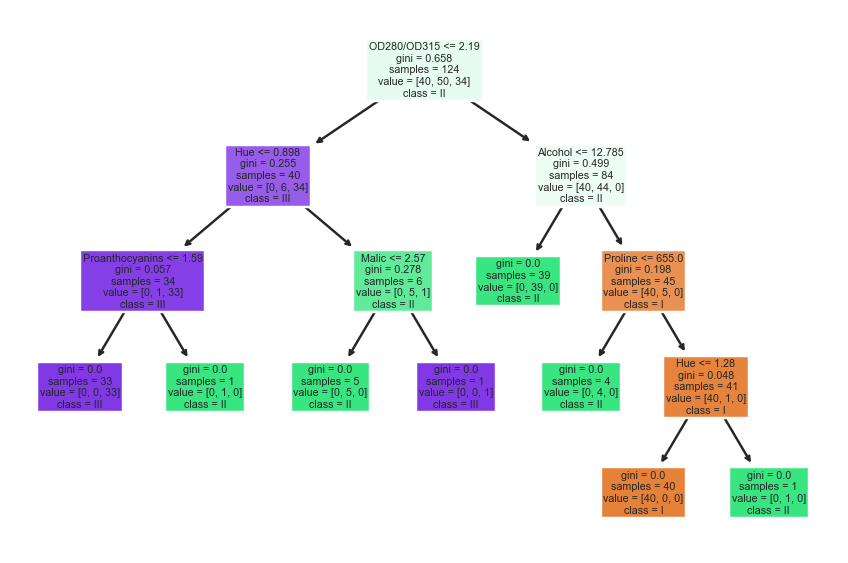

min_samples_leaf: 1
Accuracy: 0.89
Precision: 0.89
Recall: 0.87
F1 score: 0.89
Entrenament: [1.         0.98989899 1.         1.         0.99      ]
Test       : [0.76       0.96       0.84       0.88       0.91666667]
----------------
----------------


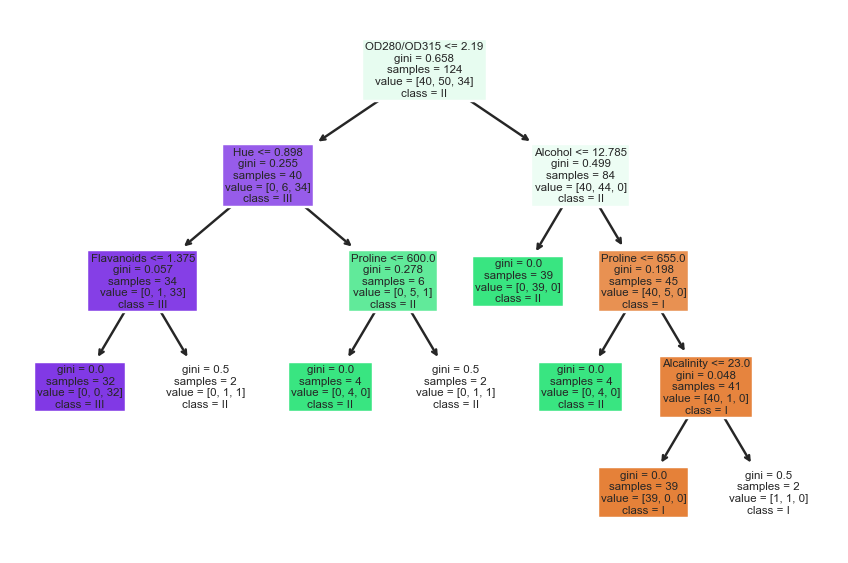

min_samples_leaf: 2
Accuracy: 0.91
Precision: 0.91
Recall: 0.89
F1 score: 0.91
Entrenament: [0.96969697 0.96969697 0.97979798 0.97979798 0.97      ]
Test       : [0.88       0.92       0.88       0.88       0.79166667]
----------------
----------------


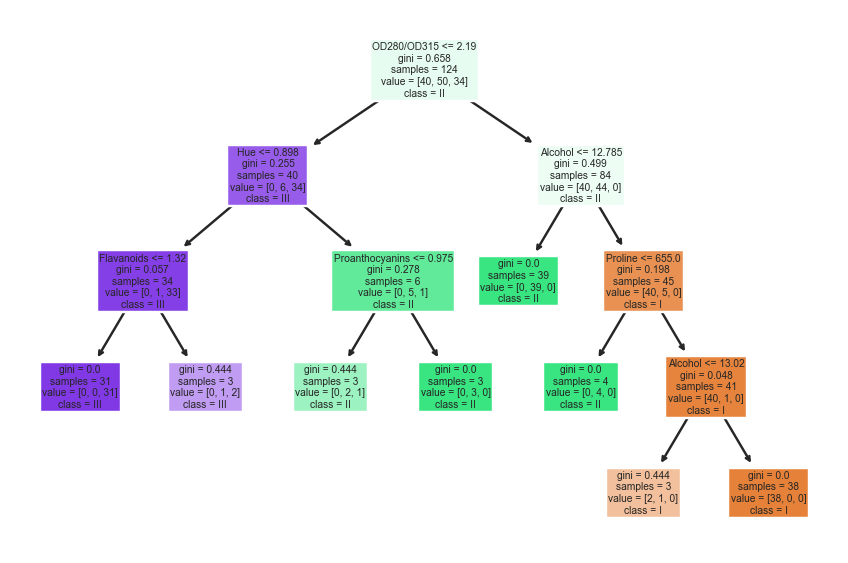

min_samples_leaf: 3
Accuracy: 0.93
Precision: 0.93
Recall: 0.91
F1 score: 0.93
Entrenament: [0.94949495 0.95959596 0.94949495 0.97979798 0.96      ]
Test       : [0.88       0.88       0.88       0.92       0.83333333]
----------------
----------------


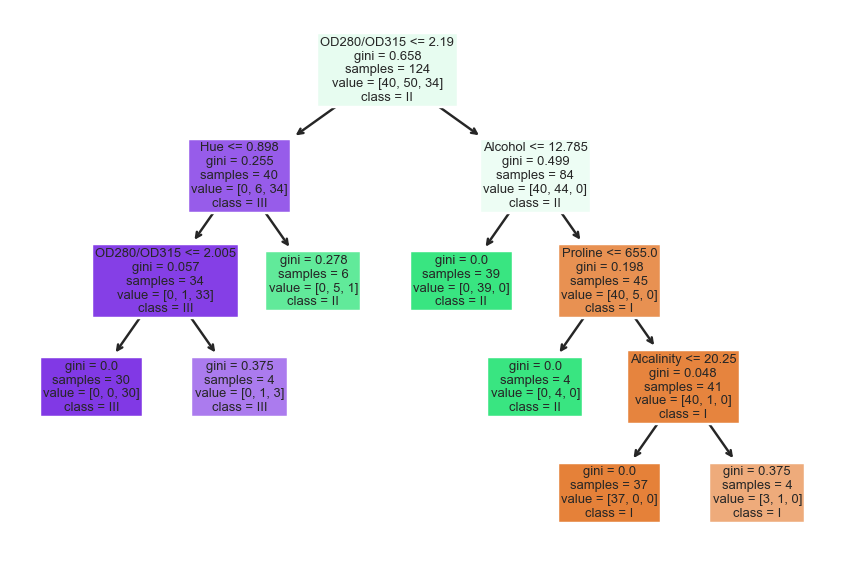

min_samples_leaf: 4
Accuracy: 0.93
Precision: 0.93
Recall: 0.91
F1 score: 0.93
Entrenament: [0.93939394 0.94949495 0.94949495 0.96969697 0.96      ]
Test       : [0.88       0.84       0.84       0.92       0.83333333]
----------------
----------------


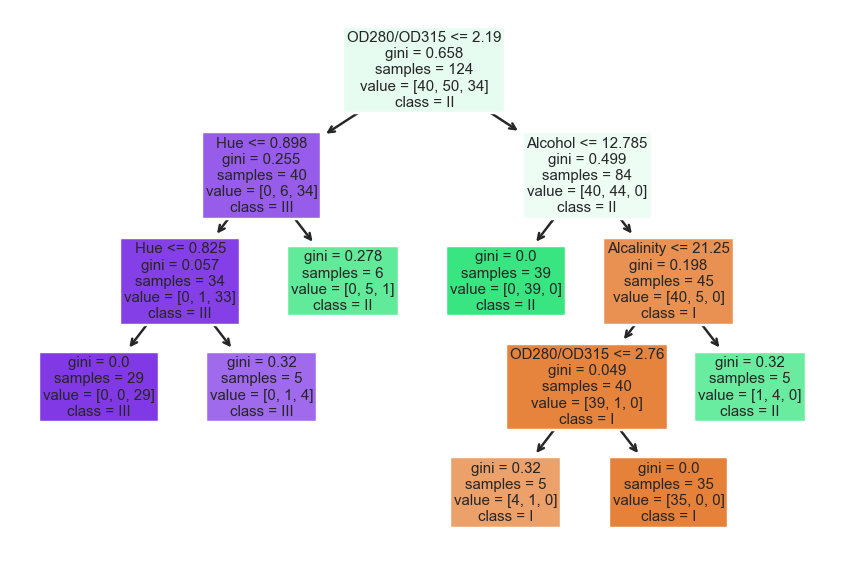

min_samples_leaf: 5
Accuracy: 0.87
Precision: 0.88
Recall: 0.86
F1 score: 0.87
Entrenament: [0.91919192 0.94949495 0.94949495 0.96969697 0.93      ]
Test       : [0.8        0.84       0.88       0.92       0.83333333]
----------------
----------------


In [105]:
dpi_sel = [125, 210, 280]
for leaf in range(1, 6):

    dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=leaf)

    dt.fit(x_train, y_train)
    dt_depth = dt.get_depth()
    y_pred = dt.predict(x_test)
    y_pred_train = dt.predict(x_train)


    plt.figure(dpi=175)

    cn = ['I', 'II', 'III'] 

    plt.show(tree.plot_tree(dt,
                   feature_names = x_col, 
                   class_names=cn,
                   filled = True))
    print(f'min_samples_leaf: {leaf}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {np.round(accuracy, 2)}')
    
    precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
    recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
    f1score = f1_score(y_test, y_pred, average='micro')
    print(f'Precision: {np.round(precision, 2)}')
    print(f'Recall: {np.round(recall, 2)}')
    print(f'F1 score: {np.round(f1score, 2)}')
    scores = cross_validate(dt, x_train, y_train, cv=5, scoring='accuracy', return_train_score=True)
    print(f'Entrenament: {scores["train_score"]}')
    print(f'Test       : {scores["test_score"]}')
    print('----------------')
    print('----------------')
    
    

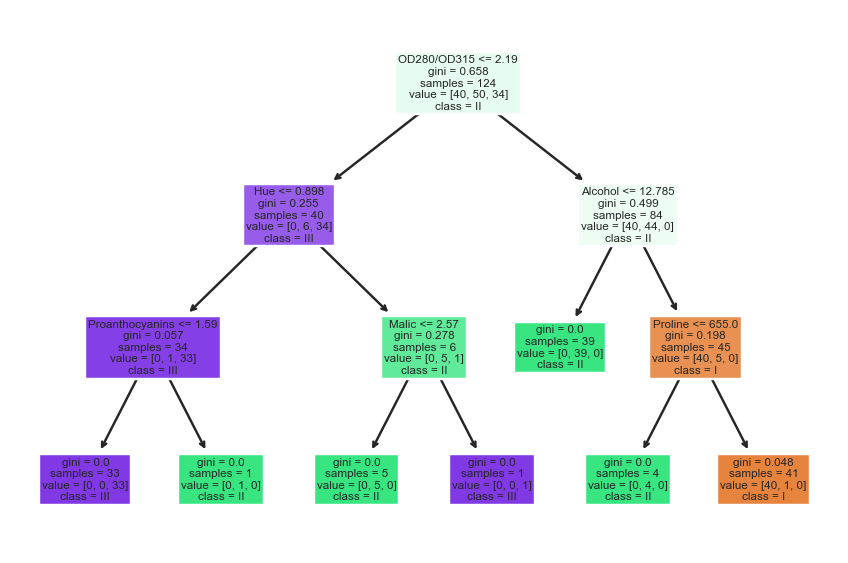

min_samples_leaf: 1
Accuracy: 0.89
Precision: 0.89
Recall: 0.87
F1 score: 0.89
Entrenament: [0.98989899 0.97979798 0.97979798 0.98989899 0.98      ]
Test       : [0.72       0.84       0.84       0.88       0.91666667]
----------------
----------------


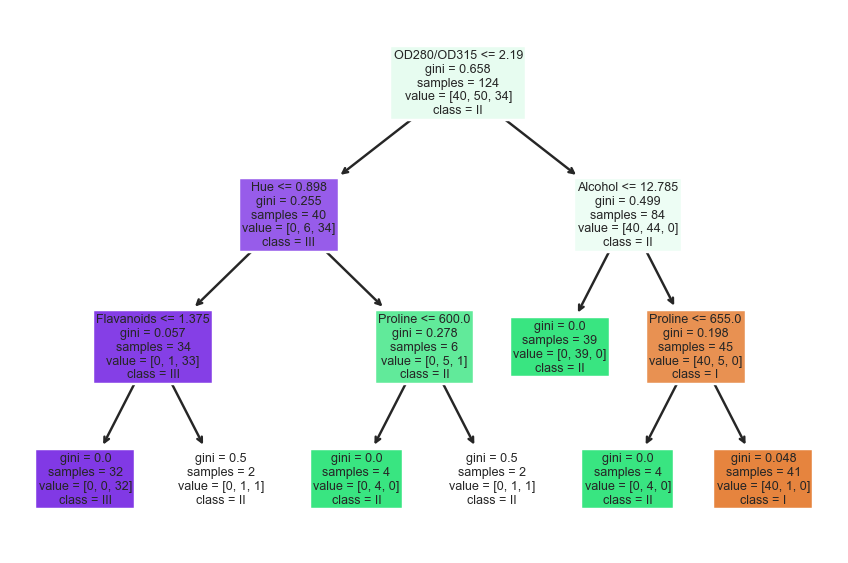

min_samples_leaf: 2
Accuracy: 0.91
Precision: 0.91
Recall: 0.89
F1 score: 0.91
Entrenament: [0.96969697 0.95959596 0.95959596 0.97979798 0.96      ]
Test       : [0.84       0.88       0.88       0.92       0.83333333]
----------------
----------------


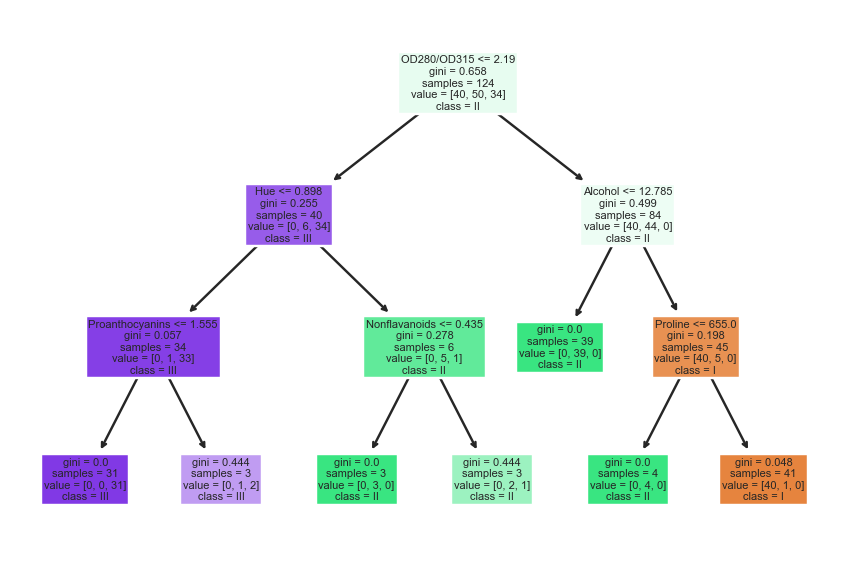

min_samples_leaf: 3
Accuracy: 0.93
Precision: 0.93
Recall: 0.91
F1 score: 0.93
Entrenament: [0.94949495 0.95959596 0.94949495 0.97979798 0.96      ]
Test       : [0.88       0.88       0.84       0.92       0.83333333]
----------------
----------------


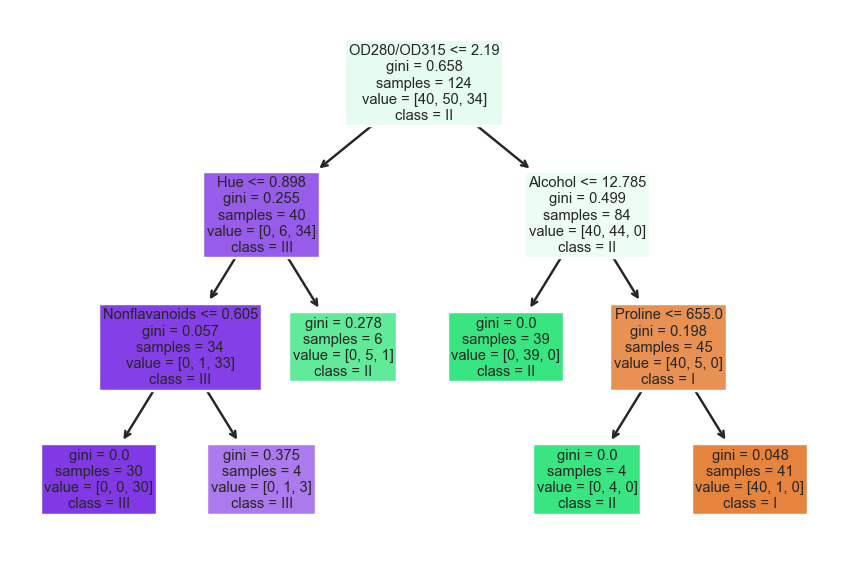

min_samples_leaf: 4
Accuracy: 0.93
Precision: 0.93
Recall: 0.91
F1 score: 0.93
Entrenament: [0.93939394 0.94949495 0.94949495 0.96969697 0.96      ]
Test       : [0.88       0.84       0.84       0.88       0.83333333]
----------------
----------------


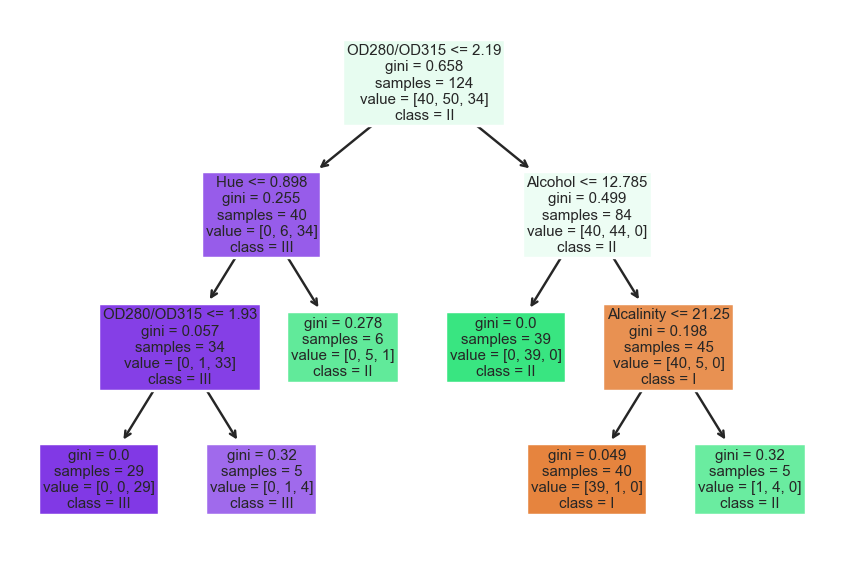

min_samples_leaf: 5
Accuracy: 0.87
Precision: 0.88
Recall: 0.86
F1 score: 0.87
Entrenament: [0.91919192 0.94949495 0.94949495 0.95959596 0.93      ]
Test       : [0.8        0.84       0.88       0.88       0.83333333]
----------------
----------------


In [106]:
dpi_sel = [125, 210, 280]
for leaf in range(1, 6):

    dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=leaf)

    dt.fit(x_train, y_train)
    dt_depth = dt.get_depth()
    y_pred = dt.predict(x_test)
    y_pred_train = dt.predict(x_train)


    plt.figure(dpi=175)

    cn = ['I', 'II', 'III'] 

    plt.show(tree.plot_tree(dt,
                   feature_names = x_col, 
                   class_names=cn,
                   filled = True))
    print(f'min_samples_leaf: {leaf}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {np.round(accuracy, 2)}')
    
    precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
    recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
    f1score = f1_score(y_test, y_pred, average='micro')
    print(f'Precision: {np.round(precision, 2)}')
    print(f'Recall: {np.round(recall, 2)}')
    print(f'F1 score: {np.round(f1score, 2)}')
    scores = cross_validate(dt, x_train, y_train, cv=5, scoring='accuracy', return_train_score=True)
    print(f'Entrenament: {scores["train_score"]}')
    print(f'Test       : {scores["test_score"]}')
    print('----------------')
    print('----------------')
    
    

Si sols modifiquem el paràmetre max_depth, podem quedar-nos amb un valor de 3 però podem obtenir un millor rendiment si, amb un max_depth de 4, modifiquem el paràmetre min_samples_leaf. El major rendiment s'obté amb un valor de 3 o 4. A més, que es redueix l'overfitting. Ens quedem, doncs, amb els paràmetres 
(max_depth=4, min_samples_leaf=3)


In [107]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=3)

dt.fit(x_train, y_train)
dt_depth = dt.get_depth()
y_pred = dt.predict(x_test)
y_pred_train = dt.predict(x_train)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
f1score = f1_score(y_test, y_pred, average='micro')

In [108]:
coef_df['DecTree_D4_L3'] = [np.round(accuracy,2), np.round(precision, 2), np.round(recall, 2), np.round(f1score, 2)]

#### 2. Model k-nearest neighbors

Provem amb un model de K-nearest neighbors. En aquest model cal elegir el número n_neighbors, s'elegeix inicialment 10.

In [109]:
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(x_train, y_train)
unknown_points = x_test
y_pred = classifier.predict(unknown_points)

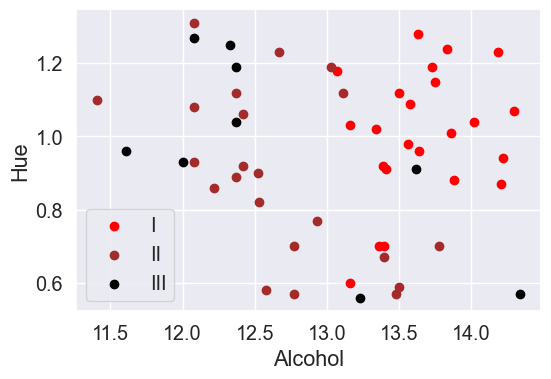

In [110]:
x = 'Alcohol'
y = 'Hue'

d = {x:x_test[x], y:x_test[y], 'y_pred':y_pred}
plot_df = pd.DataFrame(data = d)

fig = plt.figure(dpi=100)
ax = fig.add_subplot()
lab_class = ['I', 'II', 'III']

colors = ['red', 'brown', 'black']
for i in range(1, 4):
    filter = plot_df['y_pred'] == i
    plot_class = plot_df[filter]
    ax.scatter(plot_class[x], plot_class[y],  c=colors[i-1], label=lab_class[i-1])
    plt.xlabel(x)
    plt.ylabel(y)
    
ax.legend()

Es pot comprovar amb un scatter plot com el model assigna cada mostra a una classe diferent. De moment, i si es compara **Hue** amb **Alcohol**, no sembla que aquest model sigui massa fiable.

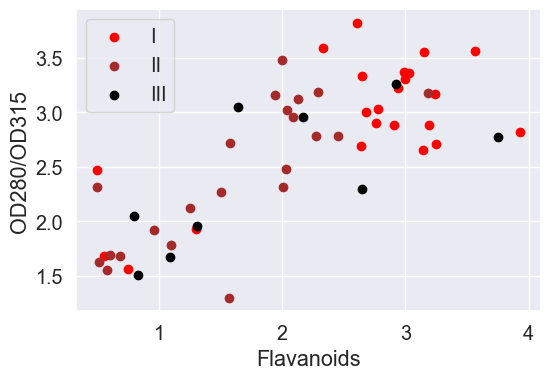

In [111]:
x = 'Flavanoids'
y = 'OD280/OD315'

d = {x:x_test[x], y:x_test[y], 'y_pred':y_pred}
plot_df = pd.DataFrame(data = d)

fig = plt.figure(dpi=100)
ax = fig.add_subplot()
lab_class = ['I', 'II', 'III']

colors = ['red', 'brown', 'black']
for i in range(1, 4):
    filter = plot_df['y_pred'] == i
    plot_class = plot_df[filter]
    ax.scatter(plot_class[x], plot_class[y],  c=colors[i-1], label=lab_class[i-1])
    plt.xlabel(x)
    plt.ylabel(y)
    
ax.legend()

També ho podem veure si enfronem **OD280/OD315** amb **Flavanoids**

In [113]:
accuracy = accuracy_score(y_test, y_pred)
print(f'model accuracy: {accuracy}')

confusion_test = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])

model accuracy: 0.6666666666666666


Confusion matrix, without normalization
[[19  0  0]
 [ 1 14  6]
 [ 3  8  3]]


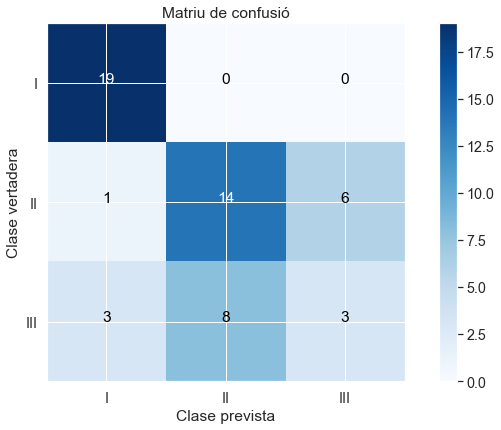

In [114]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.3)
plot_confusion_matrix(confusion_test, 
                      classes=['I','II', 'III'],
                      normalize= False,  
                      title='Matriu de confusió')

És evident que respecte amb el model anterior, aquest té un rendiment molt dolent

In [116]:
precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
print(f'Precision: {np.round(precision, 2)}')
print(f'Recall: {np.round(recall, 2)}')
f1score = f1_score(y_test, y_pred, average='micro')
print(f'F1 score: {np.round(f1score, 2)}')

Precision: 0.6
Recall: 0.63
F1 score: 0.67


In [117]:
coef_df['NK_O'] = [np.round(accuracy,2), np.round(precision, 2), np.round(recall, 2), np.round(f1score, 2)]

In [118]:
coef_df

,DecTree_O,DecTree_D4_L3,NK_O
Accuracy,0.91,0.93,0.67
Precision,0.91,0.93,0.60
Recall,0.89,0.91,0.63
F1score,0.91,0.93,0.67


El rendiment es prou roí si es comparara amb l'arbre de decissió. En aquest cas, per a un model tipus Model k-nearest neighbors, convé normalitzar les dades d'entrada. Sinó, les variables amb magnituds d'ordre superiors afecten més en el resultat que els altres.

In [119]:
mmscaler = MinMaxScaler()

for col in x_col:
    
    reshaped = np.array(wines[col]).reshape(-1,1)
    
    normalized = mmscaler.fit_transform(reshaped)
    
    if col == 'Alcohol':
        wines_norm = pd.DataFrame(normalized, columns=[col])
    else:
        wines_norm[col] = normalized
    
# Separem el dataframe en un conjunt per entrenar el model i un altre per aplicar-lo.
wines_train_n, wines_test_n = train_test_split(wines_norm, test_size=test_size_sel, random_state=42)

x_train_n = wines_train_n[col_sel]
x_test_n = wines_test_n[col_sel]

In [123]:
x_train_n.describe() # Comprovem que es troben normalitzades les dades

,Alcohol,Malic,Alcalinity,Total phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Hue,OD280/OD315,Proline
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,0.508765,0.328653,0.458763,0.445968,0.351759,0.441875,0.373181,0.389693,0.487298,0.327579
std,0.221444,0.217849,0.179595,0.225435,0.213261,0.238882,0.183485,0.190048,0.267991,0.217336
min,0.000000,0.029644,0.000000,0.000000,0.000000,0.000000,0.003155,0.000000,0.000000,0.000000
25%,0.331579,0.177866,0.347938,0.246552,0.175633,0.264151,0.264196,0.243902,0.204212,0.157454
50%,0.503947,0.229249,0.458763,0.437931,0.376582,0.396226,0.361199,0.402439,0.553114,0.276748
75%,0.701316,0.480237,0.561856,0.627586,0.520570,0.603774,0.486593,0.520325,0.698718,0.460949
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.905136


In [124]:
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(x_train_n, y_train)
unknown_points = x_test_n
y_pred = classifier.predict(unknown_points)

accuracy = accuracy_score(y_test, y_pred)
print(f'model accuracy: {accuracy}')

# confusion matrix

confusion_test = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])

model accuracy: 0.9444444444444444


Confusion matrix, without normalization
[[19  0  0]
 [ 1 18  2]
 [ 0  0 14]]


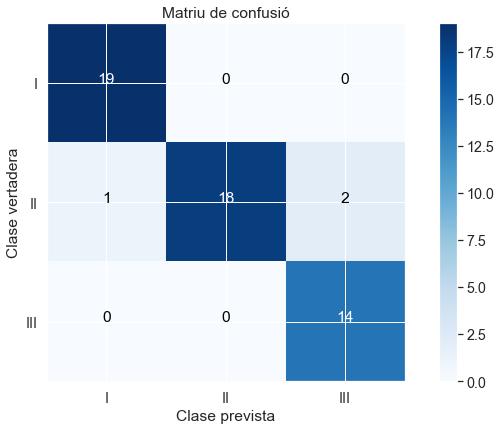

In [125]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.3)
plot_confusion_matrix(confusion_test, 
                      classes=['I','II', 'III'],
                      normalize= False,  
                      title='Matriu de confusió')

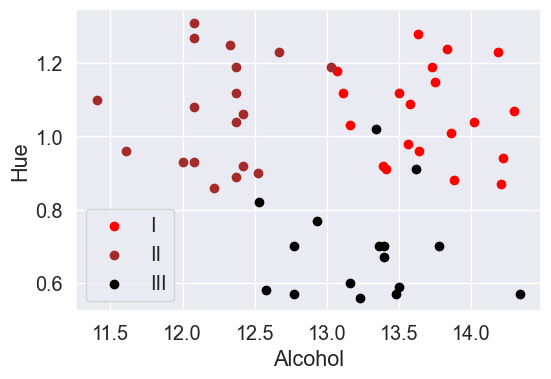

In [126]:
x = 'Alcohol'
y = 'Hue'

d = {x:x_test[x], y:x_test[y], 'y_pred':y_pred}
plot_df = pd.DataFrame(data = d)

fig = plt.figure(dpi=100)
ax = fig.add_subplot()
lab_class = ['I', 'II', 'III']

colors = ['red', 'brown', 'black']
for i in range(1, 4):
    filter = plot_df['y_pred'] == i
    plot_class = plot_df[filter]
    ax.scatter(plot_class[x], plot_class[y],  c=colors[i-1], label=lab_class[i-1])
    plt.xlabel(x)
    plt.ylabel(y)
    
ax.legend()

In [127]:
precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
print(f'Precision: {np.round(precision, 2)}')
print(f'Recall: {np.round(recall, 2)}')
f1score = f1_score(y_test, y_pred, average='micro')
print(f'F1 score: {np.round(f1score, 2)}')

Precision: 0.94
Recall: 0.95
F1 score: 0.94


In [128]:
coef_df['NK_Normalized'] = [np.round(accuracy,2), np.round(precision, 2), np.round(recall, 2), np.round(f1score, 2)]

In [129]:
coef_df

,DecTree_O,DecTree_D4_L3,NK_O,NK_Normalized
Accuracy,0.91,0.93,0.67,0.94
Precision,0.91,0.93,0.60,0.94
Recall,0.89,0.91,0.63,0.95
F1score,0.91,0.93,0.67,0.94


El rendiment millora de manera molt notable

En el model KN podem variar el número de n_neighbours. A mesura que utilitzem un número menor, podem incrementar la precisió del model però podem acabar sobreajustant el model. Iterarem augmentant de manera progresiva per veure com reacciona el model als diferents valors de n_neighbours.

In [130]:
accuracy_k = []

for k in range(1, 11):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(x_train_n, y_train)
    unknown_points = x_test_n
    y_pred = classifier.predict(unknown_points)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_k.append(accuracy)

In [131]:
accuracy_k

[0.9629629629629629,
 0.9444444444444444,
 0.9629629629629629,
 0.9629629629629629,
 0.9444444444444444,
 0.9444444444444444,
 0.9444444444444444,
 0.9444444444444444,
 0.9629629629629629,
 0.9444444444444444]

In [138]:
# FICAR?

for k in range(1, 10):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(x_train_n, y_train)
    unknown_points = x_test_n
    y_pred = classifier.predict(unknown_points)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_k.append(accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'n_neighbors:{k}')
    print(f'accuracy {np.round(accuracy, 3)}')
    scores = cross_validate(classifier, x_train_n, y_train, cv=5, scoring='accuracy', return_train_score=True)
    print(f'Entrenament: {scores["train_score"]}')
    print(f'Test       : {scores["test_score"]}')
    print('-------------------')

n_neighbors:1
accuracy 0.963
Entrenament: [1. 1. 1. 1. 1.]
Test       : [0.92       0.92       1.         0.96       0.95833333]
-------------------
n_neighbors:2
accuracy 0.944
Entrenament: [0.97979798 0.97979798 0.97979798 0.96969697 0.97      ]
Test       : [0.92       0.96       0.92       0.92       0.95833333]
-------------------
n_neighbors:3
accuracy 0.963
Entrenament: [0.96969697 0.98989899 0.96969697 0.97979798 0.96      ]
Test       : [0.92       0.96       1.         0.92       0.95833333]
-------------------
n_neighbors:4
accuracy 0.963
Entrenament: [0.95959596 0.95959596 0.94949495 0.94949495 0.97      ]
Test       : [0.92       0.92       0.92       0.88       0.91666667]
-------------------
n_neighbors:5
accuracy 0.944
Entrenament: [0.96969697 0.95959596 0.97979798 0.97979798 0.97      ]
Test       : [0.96       0.92       0.92       0.92       0.95833333]
-------------------
n_neighbors:6
accuracy 0.944
Entrenament: [0.95959596 0.93939394 0.95959596 0.93939394 0.96    

En aquest cas, les diferències entre les diferents classes son tan notables que la precisió quasi no varia. Convé  elegir un k superior a 1, ja que el model agafa de referència sols el valor més proper per a categoritzar una mostra i es produeix overfitting.

In [140]:
k = 5

classifier = KNeighborsClassifier(n_neighbors=k)
classifier.fit(x_train_n, y_train)
unknown_points = x_test_n
y_pred = classifier.predict(unknown_points)
accuracy = accuracy_score(y_test, y_pred)

precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
f1score = f1_score(y_test, y_pred, average='micro')


coef_df['NK_Normalized_k5'] = [np.round(accuracy,2), np.round(precision, 2), np.round(recall, 2), np.round(f1score, 2)]

#### 3. Random Forest

Finalment, de manera similar a com feiem amb l'arbre de decisió. Podem provar un model una mica més complexe amb el Random Forest.

In [141]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

In [142]:
accuracy = accuracy_score(y_test, y_pred)
print(f'model accuracy: {np.round(accuracy,2)}')



model accuracy: 0.98


Confusion matrix, without normalization
[[19  0  0]
 [ 0 20  1]
 [ 0  0 14]]


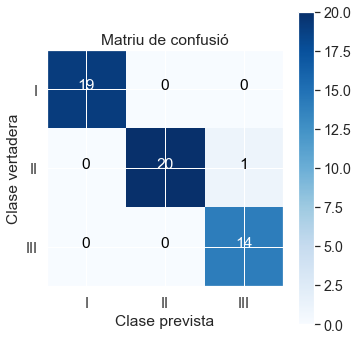

In [146]:
confusion_test = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.3)
plot_confusion_matrix(confusion_test, 
                      classes=['I','II', 'III'],
                      normalize= False,  
                      title='Matriu de confusió')

In [147]:
precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
print(f'Precision: {np.round(precision, 2)}')
print(f'Recall: {np.round(recall, 2)}')
f1score = f1_score(y_test, y_pred, average='micro')
print(f'F1 score: {np.round(f1score, 2)}')

Precision: 0.98
Recall: 0.98
F1 score: 0.98


En Random Forest també podem elegir un **max_depth** determinat. Anem a provar doncs, amb diferents valors i estudiar la seua precissió

In [154]:
for k in range(1, 9):

    rfc = RandomForestClassifier(max_depth=k, random_state=42)
    rfc.fit(x_train, y_train)
    y_pred = rfc.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'max_depth: {k}')
    print(f'model accuracy: {np.round(accuracy,2)}')
    scores = cross_validate(rfc, x_train, y_train, cv=5, scoring='accuracy', return_train_score=True)
    print(f'Entrenament: {scores["train_score"]}')
    print(f'Test       : {scores["test_score"]}')
    print('-------------------')

max_depth: 1
model accuracy: 0.94
Entrenament: [0.97979798 0.91919192 0.98989899 0.97979798 0.97      ]
Test       : [0.96       0.8        0.92       0.92       0.95833333]
-------------------
max_depth: 2
model accuracy: 0.94
Entrenament: [0.98989899 0.98989899 1.         0.98989899 0.99      ]
Test       : [1.         1.         0.92       0.92       0.95833333]
-------------------
max_depth: 3
model accuracy: 0.98
Entrenament: [0.98989899 0.98989899 1.         0.98989899 0.99      ]
Test       : [1.   1.   0.92 0.88 1.  ]
-------------------
max_depth: 4
model accuracy: 0.98
Entrenament: [1. 1. 1. 1. 1.]
Test       : [1.   1.   0.92 0.92 1.  ]
-------------------
max_depth: 5
model accuracy: 0.98
Entrenament: [1. 1. 1. 1. 1.]
Test       : [1.   1.   0.92 0.92 1.  ]
-------------------
max_depth: 6
model accuracy: 0.98
Entrenament: [1. 1. 1. 1. 1.]
Test       : [1.   1.   0.92 0.92 1.  ]
-------------------
max_depth: 7
model accuracy: 0.98
Entrenament: [1. 1. 1. 1. 1.]
Test       :

Obtenim una precisió molt bona pràcticament amb qualsevol k però el model pateix d'overfitting si el max_depth supera el 3. Així que ens quedem amb eixe valor.

In [156]:
rfc = RandomForestClassifier(max_depth=3, random_state=42)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

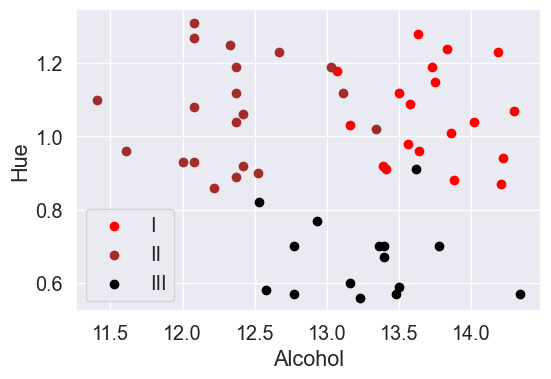

In [157]:
x = 'Alcohol'
y = 'Hue'

d = {x:x_test[x], y:x_test[y], 'y_pred':y_pred}
plot_df = pd.DataFrame(data = d)

fig = plt.figure(dpi=100)
ax = fig.add_subplot()
lab_class = ['I', 'II', 'III']

colors = ['red', 'brown', 'black']
for i in range(1, 4):
    filter = plot_df['y_pred'] == i
    plot_class = plot_df[filter]
    ax.scatter(plot_class[x], plot_class[y],  c=colors[i-1], label=lab_class[i-1])
    plt.xlabel(x)
    plt.ylabel(y)
    
ax.legend()

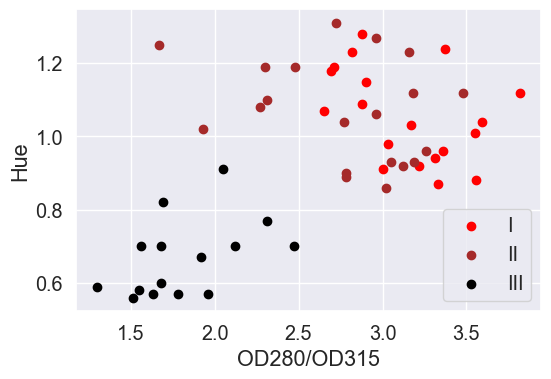

In [153]:
x = 'OD280/OD315'
y = 'Hue'

d = {x:x_test[x], y:x_test[y], 'y_pred':y_pred}
plot_df = pd.DataFrame(data = d)

fig = plt.figure(dpi=100)
ax = fig.add_subplot()
lab_class = ['I', 'II', 'III']

colors = ['red', 'brown', 'black']
for i in range(1, 4):
    filter = plot_df['y_pred'] == i
    plot_class = plot_df[filter]
    ax.scatter(plot_class[x], plot_class[y],  c=colors[i-1], label=lab_class[i-1])
    plt.xlabel(x)
    plt.ylabel(y)
    
ax.legend()

In [158]:
precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
f1score = f1_score(y_test, y_pred, average='micro')

In [161]:
coef_df['RF_5'] = [np.round(accuracy,2), np.round(precision, 2), np.round(recall, 2), np.round(f1score, 2)]

In [162]:
coef_df

,DecTree_O,DecTree_D4_L3,NK_O,NK_Normalized,NK_Normalized_k5,RF,RF_5
Accuracy,0.91,0.93,0.67,0.94,0.94,0.98,0.98
Precision,0.91,0.93,0.60,0.94,0.94,0.98,0.98
Recall,0.89,0.91,0.63,0.95,0.95,0.98,0.98
F1score,0.91,0.93,0.67,0.94,0.94,0.98,0.98


Vegem com el model que millor rendeix és, sense dubte, el Random Forest. Mentre que els altres dos, una vegada elegits be els paràmetres, mostren un rendiment similar.

In [ ]:
dfdsFdf

In [ ]:
# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(dpi=175)
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [ ]:
x_test

In [ ]:
x = 'Alcohol'
y = 'Hue'
z = 'OD280/OD315'

d = {x:x_test[x], y:x_test[y], z:x_test[z], 'y_pred':y_pred}
plot_df = pd.DataFrame(data=d)

colors = ['red', 'brown', 'black']

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

#ax.scatter(plot_df[x], plot_df[y], plot_df[z],  c=colors[i-1])
#plt.show()

colors = ['red', 'brown', 'black']
for i in range(1, 4):
    filter = plot_df['y_pred'] == i
    plot_class = plot_df[filter]
    plt.scatter(plot_class[x], plot_class[y], plot_class[z], c=colors[i-1])
    plt.xlabel(x)
    plt.ylabel(y)
    ax.set_zlabel(z)

In [ ]:
x = 'Alcohol'
y = 'Hue'
z = 'OD280/OD315'

d = {x:x_test[x], y:x_test[y], z:x_test[z], 'y_pred':y_pred}
plot_df = pd.DataFrame(data=d)

colors = ['red', 'brown', 'black']

fig = plt.figure(figsize=(8, 8))

#ax.scatter(plot_df[x], plot_df[y], plot_df[z],  c=colors[i-1])
#plt.show()

import plotly.express as px

for i in range(1, 4):
    filter = plot_df['y_pred'] == i
    plot_class = plot_df[filter]
    px.scatter_3d(plot_class, x=x, y=y, z=z, color='y_pred')
    #plt.scatter(plot_class[x], plot_class[y], plot_class[z], c=colors[i-1])
    #plt.xlabel(x)
    #plt.ylabel(y)
    #ax.set_zlabel(z)

In [ ]:
px.scatter_3d(plot_class, x=x, y=y, z=z, color='y_pred')

In [ ]:
plot_class[x]

In [ ]:
x = 'Alcohol'
y = 'Hue'

d = {x:x_test[x], y:x_test[y], 'y_pred':y_pred}
plot_df = pd.DataFrame(data = d)

colors = ['red', 'brown', 'black']
for i in range(1, 4):
    filter = plot_df['y_pred'] == i
    plot_class = plot_df[filter]
    plt.scatter(plot_class[x], plot_class[y],  c=colors[i-1])
    plt.xlabel(x)
    plt.ylabel(y)

In [ ]:
fig = plt.figure(figsize=(8, 8))
df = px.data.iris()
print(df)
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
              color='species')
fig.show()